In [1]:
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
import json
import cv2
import os
import sys
sys.path.append('../utils')

from train_eval import Evaluation

root_directory = Path("../data")
images_directory = root_directory / "images"
annots_directory =  root_directory / "annotations"
bbox_directory =  root_directory / "annotations-bbox"
masks_directory =  root_directory / "annotations-seg"

<ipython-input-1-82e9636fbf6d>:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Register Dataset

In [2]:
from detectron2.data.datasets import register_coco_instances
from detectron2.data import MetadataCatalog, DatasetCatalog

path_to_train = annots_directory / 'modanet_instance_segmentation_train.json'
path_to_test = annots_directory / 'modanet_instance_segmentation_test.json'


register_coco_instances('modanet_instance_segmentation_train', {}, path_to_train, images_directory)
register_coco_instances('modanet_instance_segmentation_test', {}, path_to_test, images_directory)

MetadataCatalog.get('modanet_instance_segmentation_train').set(
    thing_classes=['bag', 'dress', 'footwear', 'skirt', 'top', 'sunglasses', \
                   'headwear', 'shorts', 'pants', 'belt', 'outer', 'scarf', 'boots']
)
train_metadata = MetadataCatalog.get('modanet_instance_segmentation_train')

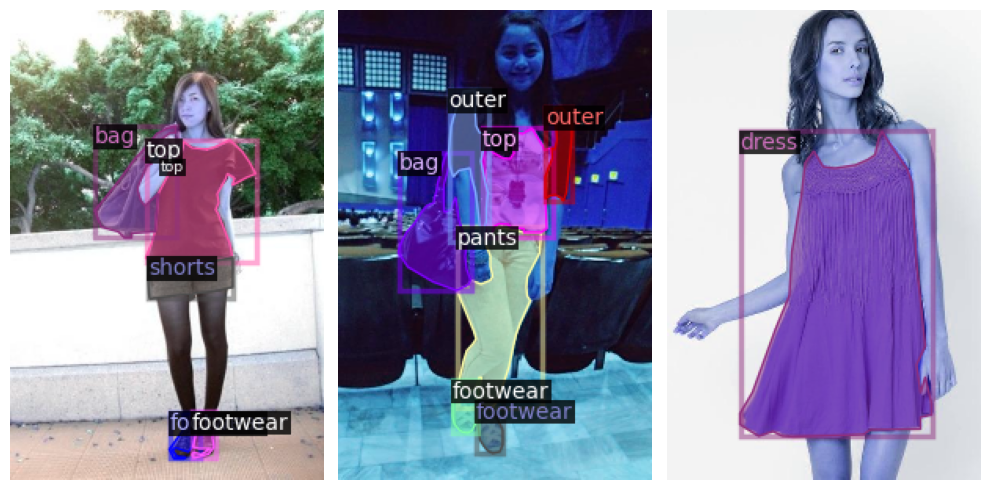

In [3]:
from detectron2.data.datasets import load_coco_json
dataset_dicts = load_coco_json("../data/annotations/modanet_instance_segmentation_train.json", "../data/images/")

f = Evaluation._show_n(dataset_dicts, train_metadata, predictions=False)

## Mask-RCNN

In [4]:
import detectron2
# from detectron2.utils.logger import setup_logger
# setup_logger()
from detectron2 import model_zoo

import random
random.seed(600)

### Training

In [5]:
import logging

from detectron2.checkpoint import DetectionCheckpointer
from detectron2.config import LazyConfig, instantiate
from detectron2.engine import (
    AMPTrainer,
    SimpleTrainer,
    default_setup,
    default_argument_parser,
    default_writers,
    hooks,
    launch
)
from detectron2.engine.defaults import create_ddp_model
from detectron2.evaluation import inference_on_dataset, print_csv_format
from detectron2.utils import comm

In [24]:
from torch.optim import Adam

def create_lazy_cfg(lazy_path, max_iter = 100):
    print(f"Creating {lazy_path}...\n")
    cfg = LazyConfig.load(model_zoo.get_config_file(lazy_path))
    default_setup(cfg, [])
    
    # training
    cfg.train.init_checkpoint = 'model_final_14d201.pkl'
    cfg.train.amp.enabled = True
    cfg.train.output_dir = '../logs/maskrcnn_new_v3'
    cfg.train.max_iter = max_iter
    
    # model
    model = cfg.model
    model.backbone.bottom_up.stem.norm = \
    model.backbone.bottom_up.stages.norm = \
    model.backbone.norm = "FrozenBN"
    cfg.model = model
    cfg.model.roi_heads.batch_size_per_image = 16
    cfg.model.roi_heads.num_classes = 13
    
    # data
    cfg.dataloader.train.total_batch_size = 4
    cfg.dataloader.train.dataset.names = 'modanet_instance_segmentation_train'
    cfg.dataloader.test.dataset.names = 'modanet_instance_segmentation_test'
    
    # optimization
    cfg.optimizer.lr = 0.003
    cfg.lr_multiplier.scheduler.milestones = (700, 800, 900)
    cfg.optimizer._target_ = Adam
    
    return cfg

def do_train(cfg):
    model = instantiate(cfg.model)
    logger = logging.getLogger("detectron2")
    logger.info("Model:\n{}".format(model))
    model.to(cfg.train.device)

    cfg.optimizer.params.model = model
    optim = instantiate(cfg.optimizer)

    train_loader = instantiate(cfg.dataloader.train)

    model = create_ddp_model(model, **cfg.train.ddp)
    trainer = (AMPTrainer if cfg.train.amp.enabled else SimpleTrainer)(model, train_loader, optim)
    checkpointer = DetectionCheckpointer(
        model,
        cfg.train.output_dir,
        optimizer=optim,
        trainer=trainer,
    )
    trainer.register_hooks(
        [
            hooks.IterationTimer(),
            hooks.LRScheduler(scheduler=instantiate(cfg.lr_multiplier)),
            hooks.PeriodicCheckpointer(checkpointer, **cfg.train.checkpointer)
            if comm.is_main_process()
            else None,
            hooks.EvalHook(cfg.train.eval_period, lambda: do_test(cfg, model)),
            hooks.PeriodicWriter(
                default_writers(cfg.train.output_dir, cfg.train.max_iter),
                period=cfg.train.log_period,
            )
            if comm.is_main_process()
            else None,
        ]
    )

    checkpointer.resume_or_load(cfg.train.init_checkpoint, resume=True)
    start_iter = 0
    trainer.train(start_iter, cfg.train.max_iter)

In [7]:
def run_lazy(lazy_path, max_iter = 100):
    cfg = create_lazy_cfg(lazy_path, max_iter)
    print(do_train(cfg))
    return cfg
    
new_model_lazy_path = 'new_baselines/mask_rcnn_R_50_FPN_400ep_LSJ.py'
# cfg = run_lazy(new_model_lazy_path, 1000)
cfg = create_lazy_cfg(new_model_lazy_path)

Creating new_baselines/mask_rcnn_R_50_FPN_400ep_LSJ.py...

[08/13 14:29:01 detectron2]: Rank of current process: 0. World size: 1
[08/13 14:29:01 detectron2]: Environment info:
----------------------  ---------------------------------------------------------------------------------------------------------------------------
sys.platform            linux
Python                  3.8.11 (default, Aug  3 2021, 15:09:35) [GCC 7.5.0]
numpy                   1.20.3
detectron2              0.5 @/opt/miniconda3/envs/vision/lib/python3.8/site-packages/detectron2
Compiler                GCC 7.3
CUDA compiler           CUDA 11.1
detectron2 arch flags   /opt/miniconda3/envs/vision/lib/python3.8/site-packages/detectron2/_C.cpython-38-x86_64-linux-gnu.so; cannot find cuobjdump
DETECTRON2_ENV_MODULE   <not set>
PyTorch                 1.9.0 @/opt/miniconda3/envs/vision/lib/python3.8/site-packages/torch
PyTorch debug build     False
GPU available           Yes
GPU 0                   NVIDIA GeForce RTX 

### Evaluate

#### Customize

In [8]:
import datetime
import logging
import time
from collections import OrderedDict, abc
from contextlib import ExitStack, contextmanager
from typing import List, Union
import torch
from torch import nn

from detectron2.utils.comm import get_world_size, is_main_process
from detectron2.utils.logger import log_every_n_seconds

from detectron2.evaluation import *

def inference_on_dataset(model, data_loader, evaluator = None):
    """
    Run model on the data_loader and evaluate the metrics with evaluator.
    Also benchmark the inference speed of `model.__call__` accurately.
    The model will be used in eval mode.
    Args:
        model (callable): a callable which takes an object from
            `data_loader` and returns some outputs.
            If it's an nn.Module, it will be temporarily set to `eval` mode.
            If you wish to evaluate a model in `training` mode instead, you can
            wrap the given model and override its behavior of `.eval()` and `.train()`.
        data_loader: an iterable object with a length.
            The elements it generates will be the inputs to the model.
        evaluator: the evaluator(s) to run. Use `None` if you only want to benchmark,
            but don't want to do any evaluation.
    Returns:
        The return value of `evaluator.evaluate()`
    """
    num_devices = get_world_size()
    logger = logging.getLogger(__name__)
    logger.info("Start inference on {} batches".format(len(data_loader)))

    total = len(data_loader)  # inference data loader must have a fixed length
    if evaluator is None:
        # create a no-op evaluator
        evaluator = DatasetEvaluators([])
    if isinstance(evaluator, abc.MutableSequence):
        evaluator = DatasetEvaluators(evaluator)
    evaluator.reset()

    num_warmup = min(5, total - 1)
    start_time = time.perf_counter()
    total_data_time = 0
    total_compute_time = 0
    total_eval_time = 0
    with ExitStack() as stack:
        if isinstance(model, nn.Module):
            stack.enter_context(inference_context(model))
        stack.enter_context(torch.no_grad())

        start_data_time = time.perf_counter()
        for idx, inputs in enumerate(data_loader):
            
            total_data_time += time.perf_counter() - start_data_time
            if idx == num_warmup:
                start_time = time.perf_counter()
                total_data_time = 0
                total_compute_time = 0
                total_eval_time = 0

            start_compute_time = time.perf_counter()
            
            for idx, inp in enumerate(inputs):
                inp['image'] = inp['image'].to("cuda")
                inputs[idx] = inp
            
            outputs = model(inputs)
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            total_compute_time += time.perf_counter() - start_compute_time

            start_eval_time = time.perf_counter()
            evaluator.process(inputs, outputs)
            total_eval_time += time.perf_counter() - start_eval_time

            iters_after_start = idx + 1 - num_warmup * int(idx >= num_warmup)
            data_seconds_per_iter = total_data_time / iters_after_start
            compute_seconds_per_iter = total_compute_time / iters_after_start
            eval_seconds_per_iter = total_eval_time / iters_after_start
            total_seconds_per_iter = (time.perf_counter() - start_time) / iters_after_start
            if idx >= num_warmup * 2 or compute_seconds_per_iter > 5:
                eta = datetime.timedelta(seconds=int(total_seconds_per_iter * (total - idx - 1)))
                log_every_n_seconds(
                    logging.INFO,
                    (
                        f"Inference done {idx + 1}/{total}. "
                        f"Dataloading: {data_seconds_per_iter:.4f} s/iter. "
                        f"Inference: {compute_seconds_per_iter:.4f} s/iter. "
                        f"Eval: {eval_seconds_per_iter:.4f} s/iter. "
                        f"Total: {total_seconds_per_iter:.4f} s/iter. "
                        f"ETA={eta}"
                    ),
                    n=5,
                )
            start_data_time = time.perf_counter()

    # Measure the time only for this worker (before the synchronization barrier)
    total_time = time.perf_counter() - start_time
    total_time_str = str(datetime.timedelta(seconds=total_time))
    # NOTE this format is parsed by grep
    logger.info(
        "Total inference time: {} ({:.6f} s / iter per device, on {} devices)".format(
            total_time_str, total_time / (total - num_warmup), num_devices
        )
    )
    total_compute_time_str = str(datetime.timedelta(seconds=int(total_compute_time)))
    logger.info(
        "Total inference pure compute time: {} ({:.6f} s / iter per device, on {} devices)".format(
            total_compute_time_str, total_compute_time / (total - num_warmup), num_devices
        )
    )

    results = evaluator.evaluate()
    # An evaluator may return None when not in main process.
    # Replace it by an empty dict instead to make it easier for downstream code to handle
    if results is None:
        results = {}
    return results

def do_test(cfg, model):
    if "evaluator" in cfg.dataloader:
        ret = inference_on_dataset(
            model, instantiate(cfg.dataloader.test), instantiate(cfg.dataloader.evaluator)
        )
        print_csv_format(ret)
        return ret

#### Run Eval

In [9]:
cfg.train.init_checkpoint

'model_final_bb69de.pkl'

In [124]:
for d in instantiate(cfg.dataloader.train):
    break

[08/13 12:52:36 d2.data.datasets.coco]: Loading ../data/annotations/modanet_instance_segmentation_train.json takes 1.95 seconds.
[08/13 12:52:36 d2.data.datasets.coco]: Loading ../data/annotations/modanet_instance_segmentation_train.json takes 1.95 seconds.
WARNING [08/13 12:52:36 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

WARNING [08/13 12:52:36 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/13 12:52:36 d2.data.datasets.coco]: Loaded 41803 images in COCO format from ../data/annotations/modanet_instance_segmentation_train.json
[08/13 12:52:36 d2.data.datasets.coco]: Loaded 41803 images in COCO format from ../data/annotations/modanet_instance_segmentation_train.json
[08/13 12:52:38 d2.data.build]: Removed 0 images with no usable annotations. 41803 images left.
[08/13 12:52:38 d2.data.build]: Removed 0 images with no usable annotations. 41803 image

In [82]:
import torchvision.transforms.functional as F

batch = []
for idx, inputs in enumerate(dl):
    inputs[0]['image'] = F.resize(inputs[0]['image'], (600, 400))
    batch += inputs
    if idx == 3:
        break
batch, batch[0]['image'].shape

([{'file_name': '../data/images/122804.jpg',
   'height': 600,
   'width': 400,
   'image_id': 6,
   'image': tensor([[[124, 106,  76,  ..., 255, 255, 255],
            [149, 126, 124,  ..., 255, 255, 255],
            [172, 152, 181,  ..., 255, 255, 255],
            ...,
            [148, 150, 154,  ..., 148, 144, 145],
            [162, 162, 166,  ..., 154, 149, 146],
            [162, 164, 170,  ..., 152, 139, 128]],
   
           [[129, 110,  80,  ..., 255, 255, 255],
            [154, 131, 129,  ..., 255, 255, 255],
            [177, 156, 186,  ..., 255, 255, 255],
            ...,
            [156, 158, 162,  ..., 160, 156, 157],
            [169, 170, 173,  ..., 166, 161, 158],
            [170, 171, 177,  ..., 164, 151, 140]],
   
           [[130, 112,  81,  ..., 255, 255, 255],
            [155, 132, 130,  ..., 255, 255, 255],
            [178, 158, 187,  ..., 255, 255, 255],
            ...,
            [158, 160, 164,  ..., 166, 162, 163],
            [172, 172, 176,  ...

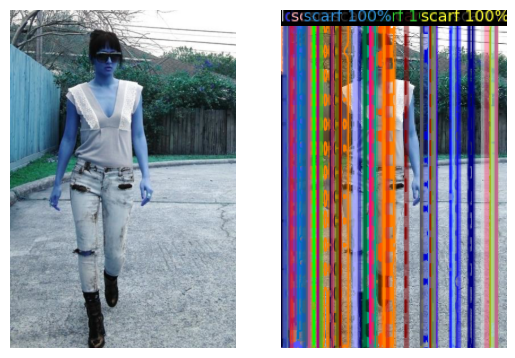

In [148]:
from detectron2.utils.visualizer import Visualizer, ColorMode

model.eval()
outputs = model(batch)
model.train()


idx = 0
im = batch[idx]['image']
v = Visualizer(im[:, :, :].permute(1, 2, 0),
    metadata=train_metadata, 
    scale=0.5, 
    instance_mode=ColorMode.IMAGE_BW
)

output = outputs[idx]
output["instances"]._fields['pred_boxes'].tensor = output["instances"]._fields['pred_boxes'].tensor.detach()

out = v.draw_instance_predictions(output["instances"].to("cpu"))

f, axs = plt.subplots(ncols=2)

axs[0].imshow(im[:, :, :].permute(1, 2, 0).numpy())
axs[0].axis("off")
axs[1].imshow(out.get_image())
axs[1].axis("off")
plt.show()

In [18]:
import os
cfg.train.init_checkpoint = os.path.join(cfg.train.output_dir, "model_final.pth") 
# cfg.model.roi_heads.test_score_thresh = 0.45
# cfg.model.proposal_generator.nms_thresh = 0.3
model = instantiate(cfg.model)
# do_test(cfg, )

In [ ]:
# eval_tools.run_coco_eval()

### Visualizations

In [153]:
[mapping[int(pred_class)] for pred_class in output["instances"]._fields["pred_classes"]]

['dress',
 'scarf',
 'dress',
 'bag',
 'scarf',
 'dress',
 'scarf',
 'bag',
 'dress',
 'dress',
 'scarf',
 'scarf',
 'scarf',
 'scarf',
 'scarf',
 'scarf',
 'dress',
 'scarf',
 'bag',
 'bag',
 'bag',
 'dress',
 'bag',
 'dress',
 'dress',
 'scarf',
 'dress',
 'scarf',
 'dress',
 'scarf',
 'dress',
 'dress',
 'scarf',
 'dress',
 'scarf',
 'dress',
 'scarf',
 'dress',
 'dress',
 'scarf',
 'scarf',
 'scarf',
 'scarf',
 'scarf']

In [147]:
[mapping[int(gt_class)] for gt_class in d[0]["instances"]._fields['gt_classes']]

['top',
 'boots',
 'boots',
 'boots',
 'boots',
 'belt',
 'pants',
 'top',
 'bag',
 'bag',
 'outer',
 'outer']

In [137]:
import copy
from detectron2.data import detection_utils as utils
import detectron2.data.transforms as T
import torch


def custom_mapper(dataset_dict):
    dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
    image = utils.read_image(dataset_dict["file_name"], format="BGR")
    transform_list = [
        T.Resize((600,400)),
        T.PadTransform(10, 10, 10, 10),
        T.RandomBrightness(0.8, 1.8),
        T.RandomContrast(0.6, 1.3),
        T.RandomSaturation(0.8, 1.4),
        T.RandomLighting(0.7),
    ]
    image, transforms = T.apply_transform_gens(transform_list, image)
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
    ]
    instances = utils.annotations_to_instances(annos, image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    return dataset_dict

custom_mapper(d[0])

KeyError: 'annotations'

In [128]:
# from detectron2.engine import DefaultPredictor

# cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, 'model_final.pth')
# cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.4 # original 0.5
# cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.4  # set the testing threshold for this model
# cfg.DATASETS.TEST = ('modanet_instance_segmentation_test', )
# predictor = DefaultPredictor(cfg)

train_metadata = MetadataCatalog.get('modanet_instance_segmentation_train')
test_dataset_dicts = DatasetCatalog.get('modanet_instance_segmentation_test')

WARNING [08/13 13:09:58 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

WARNING [08/13 13:09:58 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/13 13:09:58 d2.data.datasets.coco]: Loaded 10451 images in COCO format from ../data/annotations/modanet_instance_segmentation_test.json
[08/13 13:09:58 d2.data.datasets.coco]: Loaded 10451 images in COCO format from ../data/annotations/modanet_instance_segmentation_test.json


In [ ]:
eval_tools.show_n(dataset_dicts=test_dataset_dicts, metadata=train_metadata, predictions = True)

In [144]:
mapping = {k: v for k, v in enumerate(train_metadata.thing_classes)}
mapping

{0: 'bag',
 1: 'dress',
 2: 'footwear',
 3: 'skirt',
 4: 'top',
 5: 'sunglasses',
 6: 'headwear',
 7: 'shorts',
 8: 'pants',
 9: 'belt',
 10: 'outer',
 11: 'scarf',
 12: 'boots'}

In [ ]:
test_annots = eval_tools.createAnnots(test_dataset_dicts, mapping = mapping, sample_ratio=2)

In [ ]:
# model_predictions = modanet_segmentation_dataset.create_annotation_set(
#     annotation_task = 'Instance Segmentation', name = 'exploration_preds_sampleratio2')

# modanet_segmentation_dataset.add_annotations(test_annots, annotation_set_id=model_predictions.id)

In [ ]:
modanet_segmentation_dataset.view()